In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install scanpy --quiet

In [3]:
!pip install matplotlib==3.4 --quiet

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import h5py
import matplotlib.pyplot as plt

from scipy import sparse
from collections import Counter

In [2]:
adata = ad.read_h5ad("drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
adata.X[:10,:10].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 2.194758  ],
       [0.41061893, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.27813566,
        0.5562713 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [7]:
adata.var['feature_types'].value_counts()

ATAC    116490
GEX      13431
Name: feature_types, dtype: int64

In [8]:
adata.layers['counts'].get_shape()

(69249, 129921)

In [9]:
adata.layers['counts'][:10,:10].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Process and store GEX AnnData

In [ ]:
adata_gex = adata[:, adata.var.feature_types=="GEX"].copy()
# adata_atac = adata[:, adata.var.feature_types=="ATAC"]
# del(adata)

In [ ]:
adata_gex

Remove the metadata related to ATAC for GEX data:

In [12]:
for key in ['ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal']:
  adata_gex.obs.pop(key)

In [13]:
for key in ['ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap']:
  adata_gex.obsm.pop(key)

In [14]:
adata_gex

AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [15]:
adata_gex.X

<69249x13431 sparse matrix of type '<class 'numpy.float32'>'
	with 76997578 stored elements in Compressed Sparse Row format>

In [16]:
adata_gex.X[:10,:10].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 2.194758  ],
        [0.41061893, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.27813566,
         0.5562713 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [17]:
adata_gex.layers['counts'][:10,:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
adata_gex.layers['log_norm'] = sparse.csr_matrix(np.log(adata_gex.X.todense() + 1))

In [19]:
adata_gex.layers['log_norm'][:10,:10].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.1615113 ],
        [0.34402853, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.24540251,
         0.44229275, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [ ]:
ad.AnnData.write(adata_gex, "drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/GEX_processed.h5ad")

In [ ]:
del(adata_gex)

# Process and store ATAC data

In [3]:
adata_atac = adata[:, adata.var.feature_types=="ATAC"]
del(adata)

In [4]:
adata_atac

View of AnnData object with n_obs × n_vars = 69249 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
for key in ['GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase']:
  adata_atac.obs.pop(key)

In [6]:
for key in ['gene_id']:
  adata_atac.var.pop(key)

In [7]:
for key in ['GEX_X_pca', 'GEX_X_umap']:
  adata_atac.obsm.pop(key)

In [8]:
adata_atac.layers['counts']

<69249x116490 sparse matrix of type '<class 'numpy.float32'>'
	with 248342179 stored elements in Compressed Sparse Row format>

In [9]:
adata_atac.X[:10,:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [10]:
features = adata_atac.var['feature_types'].index
print(features)

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456', 'chr1-629497-630394',
       'chr1-633515-634474', 'chr1-778276-779191', 'chr1-816868-817761',
       'chr1-822804-823597',
       ...
       'GL000195.1-137376-138301', 'GL000219.1-39933-40839',
       'GL000219.1-42172-43054', 'GL000219.1-44703-45584',
       'GL000219.1-45726-46450', 'GL000219.1-90062-90937',
       'GL000219.1-99257-100160', 'KI270726.1-27152-28034',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=116490)


In [11]:
seqnames = [feature.split('-')[0] for feature in features]
Counter(seqnames)

Counter({'chr1': 11497,
         'chr10': 5449,
         'chr11': 5833,
         'chr12': 5937,
         'chr13': 2587,
         'chr14': 3938,
         'chr15': 3898,
         'chr16': 4350,
         'chr17': 6256,
         'chr18': 2192,
         'chr19': 5386,
         'chr2': 9123,
         'chr20': 3463,
         'chr21': 1426,
         'chr22': 2887,
         'chr3': 7241,
         'chr4': 4443,
         'chr5': 5573,
         'chr6': 7152,
         'chr7': 5684,
         'chr8': 4605,
         'chr9': 4789,
         'chrX': 2756,
         'chrY': 3,
         'GL000205.2': 9,
         'GL000195.1': 4,
         'GL000219.1': 6,
         'KI270726.1': 1,
         'KI270713.1': 2})

Remove chromosomes with few peaks: 'chrY', 'GL000205.2', 'GL000195.1', 'GL000219.1', 'KI270726.1', 'KI270713.1'



In [12]:
chrs_rm = ['chrY', 'GL000205.2', 'GL000195.1', 'GL000219.1', 'KI270726.1', 'KI270713.1']
index_rm = [i for i, seqname in enumerate(seqnames) if seqname not in chrs_rm]

In [13]:
adata_atac = adata_atac[:, index_rm]

In [14]:
ad.AnnData.write(adata_atac, "drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/ATAC_processed.h5ad")

## EDA on 1 cell


In [ ]:
gex_1cell = np.array(adata_gex.X[0,:].todense()).squeeze() # 1D array
atac_1cell = np.array(adata_atac.X[0,:].todense()).squeeze() # 1D array

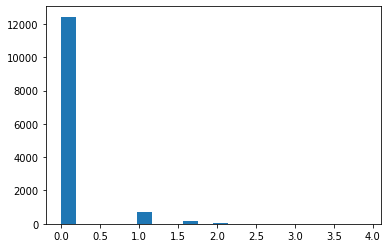

In [ ]:
# plt.figure()
plt.hist(np.log(gex_1cell+1), bins=20)
plt.show()

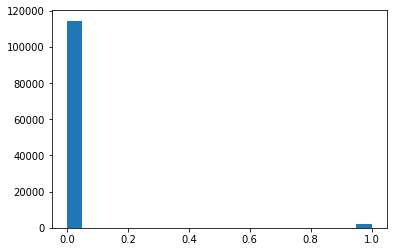

In [ ]:
plt.hist(atac_1cell, bins=20)
plt.show()